1.비지니스의 이해

본 프로젝트에서는 다음날의 통합 대기환경을 예측하는 모델을 구성해 보고자 한다. 결과 값은 regression값으로 뽑는 것을 목표로 하고 있으며, 또한 5가지의 통합적 대기 환경을 뽑아 내고자 한다. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
data = pd.read_csv("./inputdata/20180517~.csv",encoding = 'cp949')
data = data.fillna(0)
for year in range(20100101,20190101,10000):
    year = str(year)
    data1 = pd.read_csv('./inputdata/'+year + '~.csv',encoding = 'cp949')
    data1 = data1.fillna(0)
    data = pd.concat([data,data1])
data = data.drop("운형(운형약어)",axis = 1)
data = data.drop("해면기압(hPa)",axis = 1)
data = data.drop("중하층운량(10분위)",axis = 1)
data = data.drop("지점",axis = 1)
data = data.fillna(0)

c:\python\venv\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [3]:
display(data)

,강수량(mm),기온(°C),습도(%),일사(MJ/m2),일시,일조(hr),적설(cm),전운량(10분위),증기압(hPa),최저운고(100m ),풍속(m/s),풍향(16방위),현지기압(hPa)
0,0.5,22.0,97.0,0.0,2018-05-17 01:00,0.0,0.0,10.0,25.5,1.0,2.1,270.0,995.3
1,1.0,21.8,97.0,0.0,2018-05-17 02:00,0.0,0.0,10.0,25.2,1.0,1.3,270.0,995.0
2,2.5,21.8,98.0,0.0,2018-05-17 03:00,0.0,0.0,10.0,25.5,1.0,0.6,70.0,993.8
3,19.0,19.2,98.0,0.0,2018-05-17 04:00,0.0,0.0,10.0,21.7,3.0,2.4,250.0,995.1
4,0.0,18.8,97.0,0.0,2018-05-17 05:00,0.0,0.0,10.0,21.0,10.0,0.9,160.0,995.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.0,26.3,53.0,0.0,2018-05-15 20:00,0.0,0.0,0.0,18.1,11.0,1.0,290.0,998.3
3236,0.0,25.6,56.0,0.0,2018-05-15 21:00,0.0,0.0,10.0,18.3,16.0,0.7,20.0,998.2
3237,0.0,25.0,59.0,0.0,2018-05-15 22:00,0.0,0.0,0.0,18.6,11.0,0.6,270.0,998.5
3238,0.0,24.8,60.0,0.0,2018-05-15 23:00,0.0,0.0,0.0,18.8,13.0,1.0,290.0,998.4


2.데이터의 이해

 input으로 사용할 시간별 기상 데이터는 기존에 17차원으로 구성되어 있다. 그리고 output으로 사용할 일별 평균 통합대기환경은 6개의 값으로 구성되어 있다. 
 평균통합대기환경 데이터는 서울시의 각 구 별로 구분되어 저장이 되어 있기 때문에 서울시 기상을 체크하는 장소인 종로구의 데이터만 사용하여 예측 모델을 만들고자 한다.

기본적으로 운형은 type형 값을 가진 변수이다. 또한 미세먼지 예측에는 불필요한 정보라고 생각되어 Drop후에 데이터를 정리한다. input_data에 차원의 저주가 생길수도 있음을 감안하여 다양한 데이터를 drop하여 시행한다.

In [4]:
def split_day_time(data):
    day_time = data.일시.to_list()
    day = []
    time = []
    for ii in range(len(day_time)):
        today = str(day_time[ii])
        d,t = today.split(' ')
        d = d.split("-")
        d = ''.join(d)
        day.append(d)
        time.append(t)
    time = time
    data.일시 = day
    data["시간"] = time
    return data

날짜 + 시간으로 구성되어 이쓴 데이터를 날짜와 데이터로 각각 나누어 주는 함수. 또한 시간 역시 각각 스칼라로 바꾼다

In [5]:
data = split_day_time(data)

In [6]:
display(data)

,강수량(mm),기온(°C),습도(%),일사(MJ/m2),일시,일조(hr),적설(cm),전운량(10분위),증기압(hPa),최저운고(100m ),풍속(m/s),풍향(16방위),현지기압(hPa),시간
0,0.5,22.0,97.0,0.0,20180517,0.0,0.0,10.0,25.5,1.0,2.1,270.0,995.3,01:00
1,1.0,21.8,97.0,0.0,20180517,0.0,0.0,10.0,25.2,1.0,1.3,270.0,995.0,02:00
2,2.5,21.8,98.0,0.0,20180517,0.0,0.0,10.0,25.5,1.0,0.6,70.0,993.8,03:00
3,19.0,19.2,98.0,0.0,20180517,0.0,0.0,10.0,21.7,3.0,2.4,250.0,995.1,04:00
4,0.0,18.8,97.0,0.0,20180517,0.0,0.0,10.0,21.0,10.0,0.9,160.0,995.1,05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,0.0,26.3,53.0,0.0,20180515,0.0,0.0,0.0,18.1,11.0,1.0,290.0,998.3,20:00
3236,0.0,25.6,56.0,0.0,20180515,0.0,0.0,10.0,18.3,16.0,0.7,20.0,998.2,21:00
3237,0.0,25.0,59.0,0.0,20180515,0.0,0.0,0.0,18.6,11.0,0.6,270.0,998.5,22:00
3238,0.0,24.8,60.0,0.0,20180515,0.0,0.0,0.0,18.8,13.0,1.0,290.0,998.4,23:00


In [7]:
display(data.shape)

(81935, 14)

In [8]:
output_data = pd.read_csv("서울시 기간별 일평균 대기환경 정보.csv")
output_data = output_data[(output_data.측정소명 == "종로구")]
for ii in range(2010,2018):
    filename = '기간별_일평균_대기환경_정보_' + str(ii)+'년.xlsx'
    #print(filename)
    plus_data = pd.read_excel(filename)
    plus_data = plus_data[(plus_data.측정소명 == '종로구')]
    #print(len(plus_data))
    output_data = pd.concat([output_data,plus_data])
output_data = output_data.drop('권역명',axis = 1)
output_data = output_data.drop('측정소명',axis =1)
add_data = output_data.copy()
#add_data는 추후에 데이터로 넣어주기 위해 따로 분류했다.

output_data = output_data.drop('일산화탄소농도(ppm)',axis = 1)
output_data = output_data[['측정일자','미세먼지(㎍/㎥)']]
output_data = output_data.sort_values('측정일자')
output_data = output_data.reset_index(drop = True)


In [9]:
add_data = add_data.sort_values('측정일자')
add_data = add_data.reset_index(drop = True)

In [10]:
display(output_data.dtypes)

측정일자         int64
미세먼지(㎍/㎥)    int64
dtype: object

In [11]:
display(data.corr("pearson"))# input으로 사용할 데이터 가운데 상관관계 비교를 통해 비슷한 특징이 어떤것인지 골라냄

,강수량(mm),기온(°C),습도(%),일사(MJ/m2),일조(hr),적설(cm),전운량(10분위),증기압(hPa),최저운고(100m ),풍속(m/s),풍향(16방위),현지기압(hPa)
강수량(mm),1.000000,0.060848,0.178093,-0.061163,-0.068997,-0.012068,0.154282,0.140141,0.008620,0.034483,-0.042359,-0.030788
기온(°C),0.060848,1.000000,0.167674,0.284638,0.150260,-0.276296,0.225040,0.846233,0.161366,0.010145,-0.114016,-0.191915
습도(%),0.178093,0.167674,1.000000,-0.489922,-0.533562,0.025102,0.362159,0.537383,0.092641,-0.199492,-0.227215,-0.088738
일사(MJ/m2),-0.061163,0.284638,-0.489922,1.000000,0.823493,-0.033563,-0.032787,-0.003942,0.004826,0.253282,0.109129,-0.021968
일조(hr),-0.068997,0.150260,-0.533562,0.823493,1.000000,-0.006395,-0.193857,-0.117827,-0.083952,0.239900,0.131937,0.012207
적설(cm),-0.012068,-0.276296,0.025102,-0.033563,-0.006395,1.000000,-0.024356,-0.173325,-0.036096,0.008400,0.034843,0.053037
전운량(10분위),0.154282,0.225040,0.362159,-0.032787,-0.193857,-0.024356,1.000000,0.319851,0.426387,0.031910,-0.178789,-0.079288
증기압(hPa),0.140141,0.846233,0.537383,-0.003942,-0.117827,-0.173325,0.319851,1.000000,0.160649,-0.065754,-0.142209,-0.189547
최저운고(100m ),0.008620,0.161366,0.092641,0.004826,-0.083952,-0.036096,0.426387,0.160649,1.000000,-0.021492,-0.100965,-0.044000
풍속(m/s),0.034483,0.010145,-0.199492,0.253282,0.239900,0.008400,0.031910,-0.065754,-0.021492,1.000000,0.249815,-0.047098


In [12]:
#output_data = output_data.drop("초미세먼지(㎍/㎥)",axis = 1)

In [13]:
data = data.sort_values('일시')

In [14]:
def calc_day(split_input_day,split_output_day):
    target_index = []
    today = []
    
    for ii in range(len(split_output_day)):
        output_today = split_output_day[ii]
        output_today = datetime.date(output_today[0],output_today[1],output_today[2])
        today.append(output_today)
    today = set(today)
    for  jj in range(len(split_input_day)):
        input_today = split_input_day[jj]
        input_today = datetime.date(input_today[0],input_today[1],input_today[2])
        input_nextday =input_today +  datetime.timedelta(days = 1)
        if input_today in today and input_nextday in today:
            target_index.append(jj)
    return target_index

In [20]:
def drop_function(input_data, output_data):
    input_days = input_data.일시.to_list()
    split_input_day=[]
    for input_day in input_days:
        input_day = int(input_day)
        yy,day = divmod(input_day,10000)
        month, day = divmod(day,100)
        li = [yy,month,day]
        split_input_day.append(li)
    output_days = output_data.측정일자.tolist()
    split_output_day = []
    for output_day in output_days:
        output_day = int(output_day)
        yy,day = divmod(output_day,10000)
        month, day = divmod(day,100)
        li = [yy,month,day]
        split_output_day.append(li)
    target_day = calc_day(split_input_day,split_output_day)
    return input_data.iloc[target_day]
#모자른 데이터 삭제 ex) output주말 인경우

3.데이터의 준비

데이터 직접 확인 결과 input으로 사용할 시간별 기상정보 데이터와 output으로 사용될 날짜별 미세먼지 정보 데이터 모두 년 단위 365일의 데이터를 가지고 있지 않았다. 일부 빠진 데이터가 있었기 때문에 데이터를 전처리 한다. 
다음날의 통합 대기예측을 하는 모델을 만들기 때문에, input과 output의 관계는 서로 하루의 날짜가 차이가 나도록 만들었다. 또한 각각 입력/정답 의 형태의 데이터 형태를 만든다. 하루 24시간의 데이터가 없는 데이터는 삭제하여 후에 혼동이 없도록 하였다.

In [21]:
data = drop_function(data,output_data)
# 데이터에서 타겟 데이터와 입력 데이터가 적절히 맞지 않은 데이터는 제거

In [53]:
data = data.sort_values('일시')
data = data.reset_index()
data = data.drop('index',axis = 1)
#data = data.drop('level_0',axis = 1)

In [24]:
def drop_24hour(input_data):
    data_set = sorted(set(input_data.일시))
    input_list = []
    for ii in data_set:
        data = input_data[(input_data.일시 == ii)]
        tt = []
        for jj in range(len(data)):
            li = data.iloc[jj].to_list()
            tt.append(li)
            if(len(tt) == 24):
                tt.sort(key = lambda x: x[-1])
                aa = [tt[ii] for ii in range(0,24,4)]
                bb = [tt[ii] for ii in range(1,24,4)]
                cc = [tt[ii] for ii in range(2,24,4)]
                dd = [tt[ii] for ii in range(3,24,4)]
                input_list.append(aa)
                input_list.append(bb)
                input_list.append(cc)
                input_list.append(dd)
    return input_list
#24시간이 아닌 데이터 삭제

In [25]:
input_data = drop_24hour(data)

In [26]:
print(np.array(input_data).shape)
print(np.array(output_data).shape)
print(output_data.iloc[0].to_list()[0])

(12748, 6, 14)
(3218, 2)
20100101


In [27]:
def make_label(input_data,output_data):
    labels = []
    target_day =[]
    d =  sorted(set(input_data))
    for ii in range(len(d)):
        day = d[ii]
        yy,day = divmod(day,10000)
        month,day = divmod(day,100)
        target_day.append(datetime.date(yy,month,day) + datetime.timedelta(days = 1))
    for ii in range(len(output_data)):
        label_list = output_data.iloc[ii].to_list()
        day = int(label_list[0])
        yy,day = divmod(day,10000)
        month,day = divmod(day,100)
        today = datetime.date(yy,month,day)
        if today in target_day:
            for ii in range(4):
                labels.append(label_list[1:])
    return labels

make_label함수는 아웃풋으로 사용될 output값들로 사용하도록 output 데이터를 정렬하는 함수이다.

In [28]:
def make_plus(input_data,output_data):
    labels = []
    target_day =[]
    d =  sorted(set(input_data))
    for ii in range(len(d)):
        day = d[ii]
        yy,day = divmod(day,10000)
        month,day = divmod(day,100)
        target_day.append(datetime.date(yy,month,day))
    for ii in range(len(output_data)):
        label_list = output_data.iloc[ii].to_list()
        day = int(label_list[0])
        yy,day = divmod(day,10000)
        month,day = divmod(day,100)
        today = datetime.date(yy,month,day)
        if today in target_day:
            for ii in range(4):
                labels.append(label_list[:])
    return labels

def do_plus(_input,plus):   
    input_list = _input.copy()
    for ii in range(len(_input)):
        for jj in range(len(_input[ii])):
            for kk in range(len(plus[ii]) - 1):
                input_list[ii][jj].append(plus[ii][kk+1])
        #print(input_list[ii])
    return input_list

In [29]:
days = [int(input_data[ii][0][4]) for ii in range(len(input_data))]
labels = make_label(days,output_data)
print(np.array(input_data).shape)
plus_data = make_plus(days,add_data)
#print(np.array(plus_data).shape)

(12748, 6, 14)


In [30]:
print(str(output_data.columns))

Index(['측정일자', '미세먼지(㎍/㎥)'], dtype='object')


In [31]:
print(np.array(plus_data).shape)
input_data = do_plus(input_data,plus_data)

(12748, 7)


In [42]:
print(np.array(input_data).shape)
print(len(labels[0]))

(12748, 6, 20)
1


In [36]:
display(output_data)

,측정일자,미세먼지(㎍/㎥)
0,20100101,36
1,20100102,53
2,20100103,44
3,20100104,43
4,20100105,48
...,...,...
3213,20190513,48
3214,20190514,36
3215,20190515,56
3216,20190516,55


4. 모델링

미리 제안서에 제안한 모델로 모델링을 한다.

In [39]:
from keras.layers import LSTM,Dense,Input,Dropout,Flatten,GRU
from keras.models import Sequential,Model
from sklearn.model_selection import train_test_split
from keras.utils.multi_gpu_utils import multi_gpu_model

In [51]:
display(input_data[0].shape)

(6, 20)

In [55]:
#print(len(input_data[0]))
labels = make_label(days,output_data)
input_data = np.array(input_data)
labels = np.array(labels)
#display(labels)
for ii in range(len(input_data)):
    for jj in range(len(input_data[0])):
        np.delete(input_data[ii][jj],4,axis = 0)
        np.delete(input_data[ii][jj],12,axis = 0)
display(input_data)
x_train,x_test = input_data[:len(input_data)/5*4], input_data[len(input_data)/5*4:]
y_train,y_test = labels[:len(input_data)/5*4], labels[len(input_data)/5*4:]
#print(x_train[0])

array([[['0.0', '-4.5', '58.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-4.5', '83.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-3.2', '86.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-2.1', '84.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-0.4', '77.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-3.9', '63.0', ..., '0.033', '0.7', '0.009']],

       [['0.0', '-4.7', '67.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-4.2', '83.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-3.4', '90.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-0.9', '79.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-1.6', '72.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-4.7', '68.0', ..., '0.033', '0.7', '0.009']],

       [['0.0', '-4.7', '72.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-3.9', '84.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-2.9', '87.0', ..., '0.033', '0.7', '0.009'],
        ['0.0', '-0.1', '77.0', ..., '0.033', '0.7'

TypeError: slice indices must be integers or None or have an __index__ method

In [41]:
display(labels)

array([[44],
       [44],
       [44],
       ...,
       [43],
       [43],
       [43]])

In [27]:
input = Input(shape = (6,20,) )
r = LSTM(60 ,activation = 'relu',return_sequences=True)(input)
r = LSTM(40,activation = 'relu',return_sequences=False)(r)
#r = Flatten()(r)
#r = Dense(256,activation = 'relu',init = 'normal')(r)
#r = Dropout(0.2)(r)
r = Dense(512,activation = 'relu',init = 'normal')(r)
r = Dropout(0.2)(r)
r = Dense(128,activation = 'relu',init = 'normal')(r)
r = Dropout(0.2)(r)
r = Dense(len(output_data.iloc[0])-1,init = 'normal')(r)
#r = Dropout(0.2)(r)
model= Model([input],r)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6, 20)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 60)             19440     
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                16160     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               20992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)      

c:\python\venv\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, activation="relu", kernel_initializer="normal")`
  import sys
c:\python\venv\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  if __name__ == '__main__':
c:\python\venv\tensorflow\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="normal")`
  # This is added back by InteractiveShellApp.init_path()


In [28]:
model.compile(loss = 'mean_absolute_error',optimizer='adam')

In [29]:
model.fit(x_train,y_train,epochs = 30,batch_size=5,verbose =  1,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 8158 samples, validate on 2040 samples
Epoch 1/30
8158/8158 [==============================] - 8s 1ms/step - loss: 17.2223 - val_loss: 17.1392
Epoch 2/30
8158/8158 [==============================] - 7s 845us/step - loss: 16.2154 - val_loss: 16.2715
Epoch 3/30
8158/8158 [==============================] - 7s 819us/step - loss: 15.1297 - val_loss: 13.6034
Epoch 4/30
8158/8158 [==============================] - 7s 836us/step - loss: 14.5018 - val_loss: 13.9314
Epoch 5/30
8158/8158 [==============================] - 7s 848us/step - loss: 14.2980 - val_loss: 13.8704
Epoch 6/30
8158/8158 [==============================] - 7s 855us/step - loss: 14.2672 - val_loss: 13.1080
Epoch 7/30
8158/8158 [==============================] - 7s 867us/step - loss: 14.2769 - val_loss: 14.4578
Epoch 8/30
8158/8158 [==============================] - 7s 851us/step - loss: 14.3344 - val_loss: 13.0491
Epoch 9/30
8158/8158 [==============================] - 7s

In [33]:
h = model.evaluate(x_test, y_test, batch_size=5)
print(str(h[1]))

2550/2550 [==============================] - 0s 173us/step


IndexError: invalid index to scalar variable.

5.모델의 평가

test 집합으로 분류된 데이터 들을 사용하여 시각화를 통한 평가를 하거나 또는 loss함수를 사용하여 모델의 성능을 평가한다.

In [34]:
print(model.evaluate(x_test,y_test))
#print(x_test.shape,y_train.shape)

2550/2550 [==============================] - 0s 43us/step
13.343570446687586


(2550, 1)


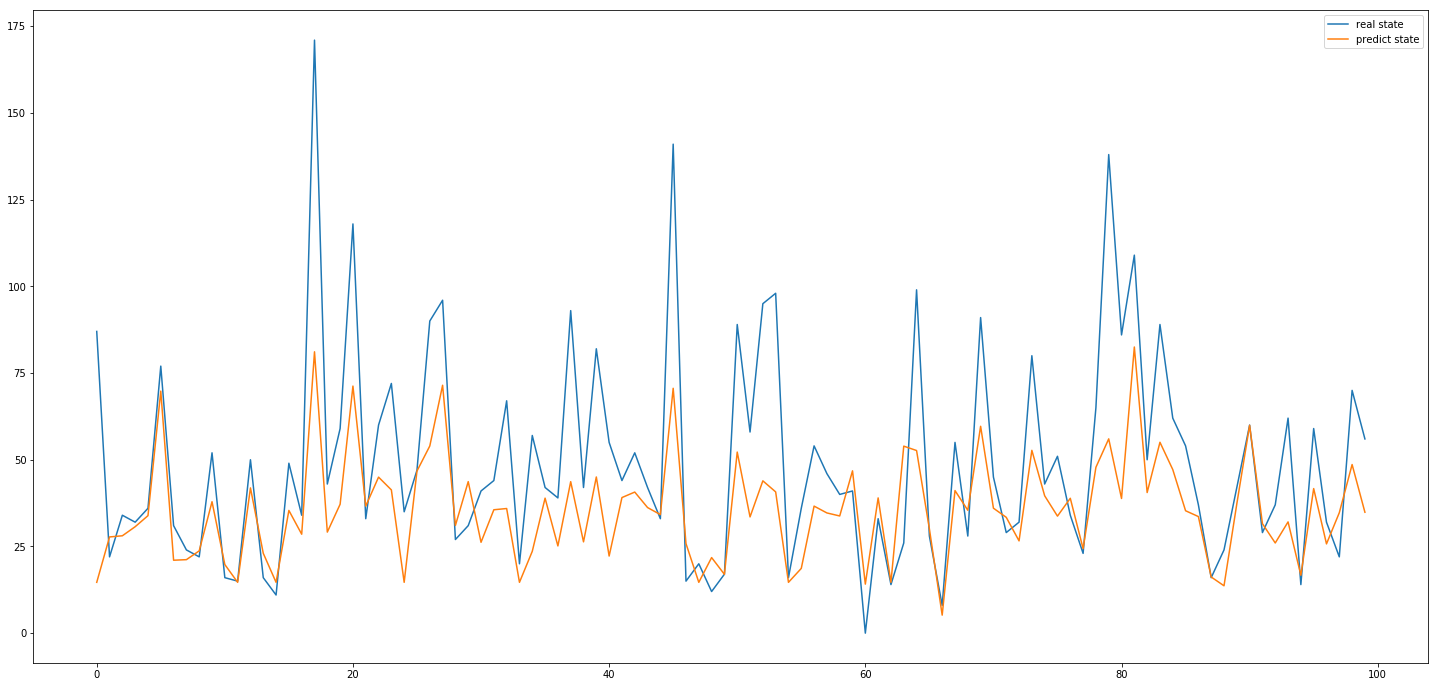

In [34]:
import matplotlib.pyplot as plt
print(y_test.shape)
#for ii,(label,x_test) in enumerate(zip(y_test , model.predict(x_test))):
plt.rcParams["figure.figsize"] = (25,12)
plt.plot(np.arange(len(y_test[:100])) , y_test[:100,0],label = 'real state')
plt.plot(np.arange(len(y_test[:100])) , model.predict(x_test[:100])[:,0].astype('float32'),label = 'predict state')
plt.legend()
plt.show()

In [38]:
model.save('datamining1.h5')#모델 저장

(20,) 87
(2550, 1)


In [35]:
def pm_check(arr):
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            if(arr[i,j]<15):
                arr[i,j] = 0
            elif(arr[i,j]<35):
                arr[i,j] = 1
            elif(arr[i,j]<75):
                arr[i,j] = 2
            else:
                arr[i,j] =3
    return arr

In [41]:
#display(model.predict(x_test[:100]),y_test[:100])
predict = pm_check(model.predict(x_test))
y = pm_check(y_test)
print(np.mean(predict==y)*100,"%")
#print(predict[:100])

100.0 %
